# Setup

In [31]:
import os
from pathlib import Path
import random

from cmdstanpy import cmdstan_path, CmdStanModel
import numpy as np
import pandas as pd
import stan
import arviz
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

In [2]:
# enable PyStan on Jupyter IDE
import nest_asyncio
nest_asyncio.apply()

In [3]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()
readRDS = robjects.r['readRDS']

Using libraries at paths:
- /home/nels/R/x86_64-pc-linux-gnu-library/4.1
- /usr/local/lib/R/site-library
- /usr/lib/R/site-library
- /usr/lib/R/library


In [4]:
random.seed(42)
rng = np.random.default_rng(42)

# Course data

In [5]:
pest_data =  readRDS('../data/pest_data.RDS')
standata_hier = readRDS('../data/standata_hier.RDS')

In [6]:
pest_data

,building_id,date,traps,floors,sq_footage_p_floor,live_in_super,monthly_average_rent,average_tenant_age,age_of_building,total_sq_foot,month,complaints,log_sq_foot_1e4
1,37,17181.0,8.0,8.0,5149.008112,0.0,3846.949050,53.877424,47.0,41192.064892,1.0,1.0,1.415661
2,37,17211.0,8.0,8.0,5149.008112,0.0,3846.949050,53.877424,47.0,41192.064892,2.0,3.0,1.415661
3,37,17241.0,9.0,8.0,5149.008112,0.0,3846.949050,53.877424,47.0,41192.064892,3.0,0.0,1.415661
4,37,17271.0,10.0,8.0,5149.008112,0.0,3846.949050,53.877424,47.0,41192.064892,4.0,1.0,1.415661
5,37,17301.0,11.0,8.0,5149.008112,0.0,3846.949050,53.877424,47.0,41192.064892,5.0,0.0,1.415661
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,98,17391.0,3.0,13.0,4557.786883,1.0,3785.183548,42.138240,39.0,59251.229483,8.0,6.0,1.779201
117,98,17421.0,2.0,13.0,4557.786883,1.0,3785.183548,42.138240,39.0,59251.229483,9.0,16.0,1.779201
118,98,17451.0,2.0,13.0,4557.786883,1.0,3785.183548,42.138240,39.0,59251.229483,10.0,5.0,1.779201
119,98,17481.0,2.0,13.0,4557.786883,1.0,3785.183548,42.138240,39.0,59251.229483,11.0,5.0,1.779201


In [7]:
pest_data.dtypes

building_id               int32
date                    float64
traps                   float64
floors                  float64
sq_footage_p_floor      float64
live_in_super           float64
monthly_average_rent    float64
average_tenant_age      float64
age_of_building         float64
total_sq_foot           float64
month                   float64
complaints              float64
log_sq_foot_1e4         float64
dtype: object

# Prior Predictive Checks

In [8]:
def simple_poisson_dgp(traps, alpha_mean, alpha_sd, beta_mean, beta_sd):
    n = len(traps)
    alpha = rng.normal(loc=alpha_mean, scale=alpha_sd, size=1)
    beta = rng.normal(loc=beta_mean, scale=beta_sd, size=1)
    complaints = rng.poisson(lam=np.exp(alpha + beta * traps), size=n)
    return complaints

## Sample from the priors

In [9]:
simple_poisson_dgp(
    traps=pest_data['traps'],
    alpha_mean=0,
    alpha_sd=1,
    beta_mean=0,
    beta_sd=1
)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [10]:
# take 1000 samples
prior_preds = pd.DataFrame(
    [
        simple_poisson_dgp(
            traps=pest_data['traps'],
            alpha_mean=0,
            alpha_sd=1,
            beta_mean=0,
            beta_sd=1
        ) for _ in range(1000)
    ]
)

In [11]:
prior_preds.shape

(1000, 120)

In [12]:
prior_preds.transpose().mean().describe()

count    1.000000e+03
mean     4.703973e+10
std      1.475804e+12
min      0.000000e+00
25%      2.500000e-02
50%      7.833333e-01
75%      1.630854e+02
max      4.666883e+13
dtype: float64

In [13]:
prior_preds.transpose().min().describe()

count    1000.000000
mean        1.929000
std         5.901253
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        90.000000
dtype: float64

In [14]:
prior_preds.transpose().max().describe()

count    1.000000e+03
mean     2.405517e+12
std      7.551901e+13
min      0.000000e+00
25%      1.000000e+00
50%      4.000000e+00
75%      1.180500e+03
max      2.388114e+15
dtype: float64

# First Stan model

In [19]:
standata_simple = {
    'N': 120, 
    'traps': pest_data.traps.astype(int).values, 
    'complaints': pest_data.complaints.astype(int).values
}

In [20]:
comp_simple_pois = stan.build(
    Path('../stan_programs/simple_poisson_regression.stan').read_text(),
    data=standata_simple
)

Building: found in cache, done.


In [23]:
fit_simple_pois = comp_simple_pois.sample(
    num_chains=4,
    num_warmup=1000,
    num_samples=2000
)

Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 5.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
  Adjust your expectations accordingly!


In [25]:
fit_df = fit_simple_pois.to_frame()

In [26]:
fit_df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,y_rep.1,...,y_rep.111,y_rep.112,y_rep.113,y_rep.114,y_rep.115,y_rep.116,y_rep.117,y_rep.118,y_rep.119,y_rep.120
draws,,,,,,,,,,,,,,,,,,,,,
0,162.048977,0.999227,0.207386,4.0,19.0,0.0,-161.780007,2.694397,-0.211340,1.0,...,1.0,7.0,2.0,6.0,5.0,4.0,8.0,7.0,9.0,10.0
1,161.448802,0.956810,0.214191,2.0,7.0,0.0,-160.811971,2.659138,-0.194290,4.0,...,5.0,3.0,4.0,4.0,6.0,5.0,11.0,14.0,7.0,8.0
2,162.043289,0.976695,0.245514,3.0,11.0,0.0,-161.274300,2.492643,-0.176665,3.0,...,3.0,1.0,2.0,4.0,7.0,6.0,9.0,8.0,5.0,10.0
3,162.161347,0.999534,0.225856,3.0,15.0,0.0,-161.766985,2.667747,-0.207235,3.0,...,4.0,7.0,2.0,3.0,6.0,3.0,6.0,10.0,15.0,8.0
4,162.165040,0.909432,0.207386,3.0,15.0,0.0,-161.140795,2.566997,-0.194192,0.0,...,3.0,3.0,2.0,1.0,3.0,6.0,12.0,4.0,9.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,161.632585,0.881256,0.225856,3.0,15.0,0.0,-160.439720,2.499195,-0.187791,1.0,...,3.0,1.0,5.0,4.0,6.0,6.0,8.0,11.0,6.0,9.0
7996,161.959128,0.999677,0.207386,4.0,19.0,0.0,-161.479932,2.464997,-0.177354,4.0,...,7.0,9.0,3.0,6.0,5.0,3.0,9.0,5.0,9.0,12.0
7997,161.769694,1.000000,0.214191,2.0,3.0,0.0,-161.761154,2.756787,-0.218371,2.0,...,8.0,3.0,7.0,5.0,8.0,8.0,16.0,5.0,12.0,15.0


/home/nels/.pyenv/versions/3.8.5/envs/stanspace/lib/python3.8/site-packages/arviz/plots/densityplot.py:204: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (122) in plot_density, generating only 40 plots
  warnings.warn(


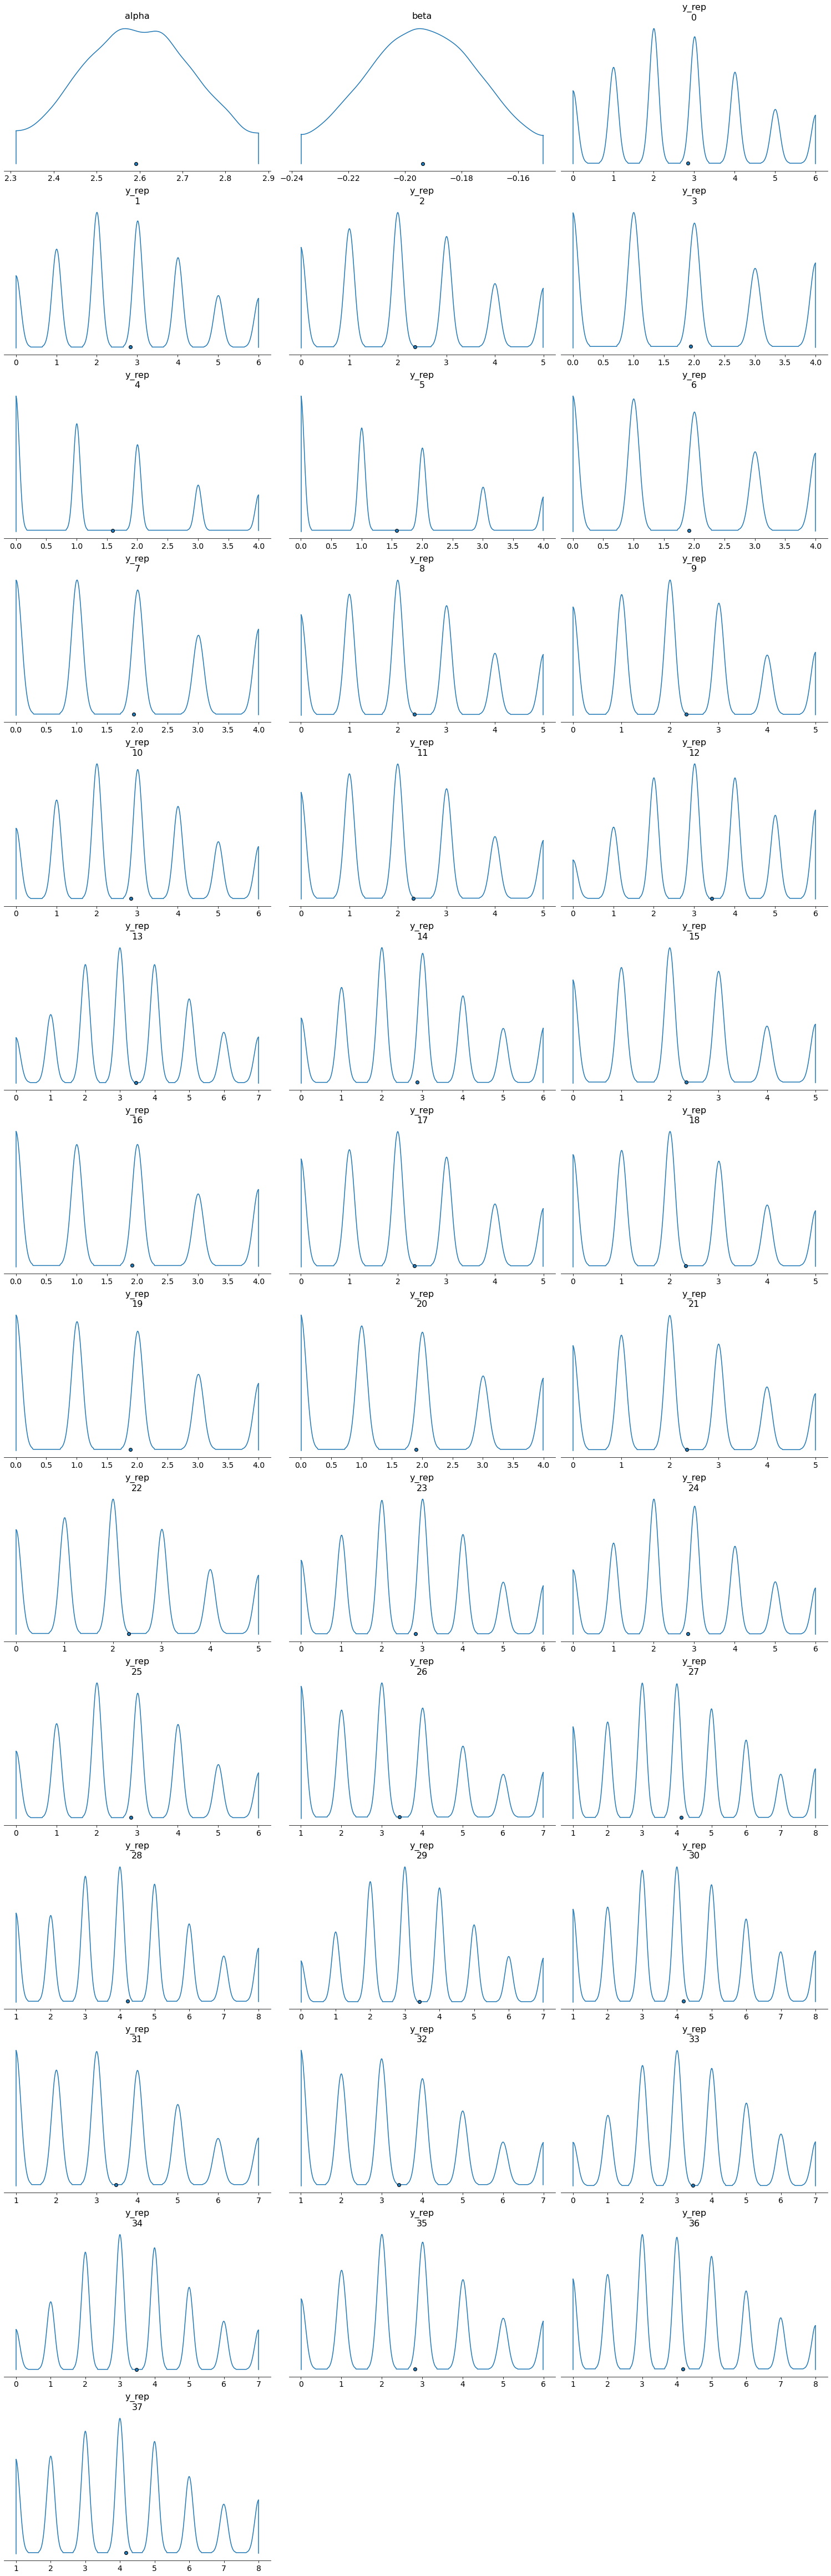

In [32]:
az.plot_density(fit_simple_pois)
plt.show()